<a href="https://colab.research.google.com/github/AnhQuocVo/ML-for-Research-Paper/blob/main/Get_Data_API_WDI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


World Bank Data360 API Data Fetcher
Fetches multiple indicators from the World Bank Data360 API

Required libraries:
pip install requests pandas

Usage:
1. Run the script to fetch all specified indicators
2. Data will be saved to CSV files
3. Combined data will be saved to 'combined_wdi_data.csv'


In [1]:
import requests
import pandas as pd
import time
from typing import List, Dict, Optional

In [2]:
class Data360APIClient:
    """Client for interacting with World Bank Data360 API"""

    BASE_URL = "https://data360api.worldbank.org"

    def __init__(self):
        self.session = requests.Session()

    def get_data(self,
                 database_id: str,
                 indicator: str,
                 ref_area: Optional[str] = None,
                 time_period_from: Optional[str] = None,
                 time_period_to: Optional[str] = None,
                 skip: int = 0) -> Dict:
        """
        Fetch data from the Data360 API

        Args:
            database_id: Database identifier (e.g., 'WB_WDI')
            indicator: Indicator ID (e.g., 'WB_WDI_SP_URB_TOTL_IN_ZS')
            ref_area: Country/region code (optional)
            time_period_from: Start year (optional)
            time_period_to: End year (optional)
            skip: Number of records to skip for pagination

        Returns:
            Dictionary containing the API response
        """
        endpoint = f"{self.BASE_URL}/data360/data"

        params = {
            'DATABASE_ID': database_id,
            'INDICATOR': indicator,
            'skip': skip
        }

        if ref_area:
            params['REF_AREA'] = ref_area
        if time_period_from:
            params['timePeriodFrom'] = str(time_period_from) # Ensure timePeriodFrom is a string
        if time_period_to:
            params['timePeriodTo'] = str(time_period_to) # Ensure timePeriodTo is a string


        try:
            response = self.session.get(endpoint, params=params)
            response.raise_for_status()
            return response.json()
        except requests.exceptions.RequestException as e:
            print(f"Error fetching data for {indicator}: {e}")
            return None

    def get_all_data(self,
                     database_id: str,
                     indicator: str,
                     ref_area: Optional[str] = None,
                     time_period_from: Optional[str] = None,
                     time_period_to: Optional[str] = None) -> pd.DataFrame:
        """
        Fetch all data for an indicator (handles pagination)

        Returns:
            DataFrame containing all records
        """
        all_data = []
        skip = 0
        max_records_per_call = 1000

        print(f"Fetching data for indicator: {indicator}")

        while True:
            result = self.get_data(
                database_id=database_id,
                indicator=indicator,
                ref_area=ref_area,
                time_period_from=time_period_from,
                time_period_to=time_period_to,
                skip=skip
            )

            if not result or 'value' not in result:
                break

            records = result['value']
            if not records:
                break

            all_data.extend(records)
            print(f"  Fetched {len(records)} records (total: {len(all_data)})")

            # Check if we've fetched all records
            if len(records) < max_records_per_call:
                break

            skip += max_records_per_call
            time.sleep(0.5)  # Be polite to the API

        if all_data:
            df = pd.DataFrame(all_data)
            print(f"  Total records fetched: {len(df)}")
            return df
        else:
            print(f"  No data found")
            return pd.DataFrame()


def main():
    """Main function to fetch all specified indicators"""

    # Initialize API client
    client = Data360APIClient()

    # Define indicators to fetch
    indicators = [
        # DEPENDENT VARIABLES
        {
            'name': 'GDP (annual % growth)',
            'database_id': 'WB_WDI',
            'indicator': 'WB_WDI_NY_GDP_MKTP_KD_ZG'
        },
        {
            'name': 'GDP (constant LCU)',
            'database_id': 'WB_WDI',
            'indicator': 'WB_WDI_NY_GDP_MKTP_KN'
        },
        {
            'name': 'GDP per capita (current US$)',
            'database_id': 'WB_WDI',
            'indicator': 'WB_WDI_NY_GDP_PCAP_CD'
        },
        {
            'name': 'GDP per capita (annual % growth)',
            'database_id': 'WB_WDI',
            'indicator': 'WB_WDI_NY_GDP_PCAP_KD_ZG'
        },
        # INSTITUTIONS INDEX
        {
            "name": "Control of Corruption: Estimate",
            "database_id": "WB_WDI",
            "indicator": "WB_WDI_CC_EST"
        },
        {
            "name": "Government Effectiveness: Estimate",
            "database_id": "WB_WDI",
            "indicator": "WB_WDI_GE_EST"
        },
        {
            "name": "Political Stability and Absence of Violence/Terrorism: Estimate",
            "database_id": "WB_WDI",
            "indicator": "WB_WDI_PV_EST"
        },
        {
            "name": "Regulatory Quality: Estimate",
            "database_id": "WB_WDI",
            "indicator": "WB_WDI_RQ_EST"
        },
        {
            "name": "Rule of Law: Estimate",
            "database_id": "WB_WDI",
            "indicator": "WB_WDI_RL_EST"
        },
        {
            "name": "Voice and Accountability: Estimate",
            "database_id": "WB_WDI",
            "indicator": "WB_WDI_VA_EST"
        },
        # DIGITAL TRANSFORMATION - INVESTMENT
        {
            'name': 'Research and development expenditure (% of GDP)',
            'database_id': 'WB_WDI',
            'indicator': 'WB_WDI_GB_XPD_RSDV_GD_ZS'
        },
        {
            'name': 'Government expenditure on education, total (% of GDP)',
            'database_id': 'WB_WDI',
            'indicator': 'WB_WDI_SE_XPD_TOTL_GD_ZS'
        },

        # INTELLECTUAL CAPITAL - HUMAN CAPITAL
        {
            'name': 'School enrollment, tertiary (% gross)',
            'database_id': 'WB_WDI',
            'indicator': 'WB_WDI_SE_TER_ENRR'
        },
        {
            'name': 'Educational attainment, at least completed primary, population 25+ years, total (%) (cumulative)',
            'database_id': 'WB_WDI',
            'indicator': 'WB_WDI_SE_PRM_CUAT_ZS'
        },
        {
            'name': 'Labor force with advanced education (% of total working-age population with advanced education)',
            'database_id': 'WEF_TTDI',
            'indicator': 'WEF_TTDI_LABOUREDUADV'
        },

        {
            'name': 'Individuals with ICT skills in problem solving',
            'database_id': 'ITU_DH',
            'indicator': 'ITU_DH_SKLS_PRB_SOLV'
        },
        {
            'name': 'Individuals with ICT skills in information and data literacy',
            'database_id': 'ITU_DH',
            'indicator': ' ITU_DH_SKLS_INF_DATA'
        },
        # INTELLECTUAL CAPITAL - STRUCTURAL CAPITAL
        {
            'name': 'Patent applications, residents',
            'database_id': 'WB_WDI',
            'indicator': 'WB_WDI_IP_PAT_RESD'
        },
        {
            'name': 'Patent applications, nonresidents',
            'database_id': 'WB_WDI',
            'indicator': 'WB_WDI_IP_PAT_NRES'
        },
        {
            'name': 'Scientific and technical journal articles',
            'database_id': 'WB_WDI',
            'indicator': 'WB_WDI_IP_JRN_ARTC_SC'
        },
        {
            'name': 'High-technology exports (% of manufactured exports)',
            'database_id': 'WB_WDI',
            'indicator': 'WB_WDI_TX_VAL_TECH_MF_ZS'
        },
        {
            'name': 'Manufacturing, value added (% of GDP)',
            'database_id': 'WB_WDI',
            'indicator': 'WB_WDI_NV_IND_MANF_ZS'
        },

        # INTELLECTUAL CAPITAL - RELATIONAL CAPITAL
        {
            'name': 'Foreign direct investment, net inflows (% of GDP)',
            'database_id': 'WB_WDI',
            'indicator': 'WB_WDI_BX_KLT_DINV_WD_GD_ZS'
        },
        {
            'name': 'Foreign direct investment, net inflows (BoP, current US$)',
            'database_id': 'WB_WDI',
            'indicator': 'WB_WDI_BX_KLT_DINV_CD_WD'
        },
        {
            'name': 'Trade (% of GDP)',
            'database_id': 'WB_WDI',
            'indicator': 'WB_WDI_NE_TRD_GNFS_ZS'
        },
        {
            'name': 'Charges for the use of intellectual property, receipts (BoP, current US$)',
            'database_id': 'WB_WDI',
            'indicator': 'WB_WDI_BX_GSR_ROYL_CD'
        },
        {
            'name': 'International tourism, receipts (% of total exports)',
            'database_id': 'WB_WDI',
            'indicator': 'WB_WDI_ST_INT_RCPT_XP_ZS'
        },

        # AI ABSORPTIVE CAPACITY - INFRASTRUCTURE
        {
            'name': 'Fixed broadband subscriptions (per 100 people)',
            'database_id': 'WB_WDI',
            'indicator': 'WB_WDI_IT_NET_BBND_P2'
        },
        {
            'name': 'Secure Internet servers (per 1 million people)',
            'database_id': 'WB_WDI',
            'indicator': 'WB_WDI_IT_NET_SECR_P6'
        },
        {
            'name': 'Individuals using the Internet (% of population)',
            'database_id': 'WB_WDI',
            'indicator': 'WB_WDI_IT_NET_USER_ZS'
        },
        {
            'name': 'Mobile cellular subscriptions (per 100 people)',
            'database_id': 'WB_WDI',
            'indicator': 'WB_WDI_IT_CEL_SETS_P2'
        },

        # AI ABSORPTIVE CAPACITY - MARKET ADVANTAGE
        {
            'name': 'ICT service exports (% of service exports, BoP)',
            'database_id': 'WB_WDI',
            'indicator': 'WB_WDI_BX_GSR_CCIS_ZS'
        },
        {
            'name': 'ICT goods exports (% of total goods exports)',
            'database_id': 'WB_WDI',
            'indicator': 'WB_WDI_TX_VAL_ICTG_ZS_UN'
        },
        {
            'name': 'ICT goods imports (% total goods imports)',
            'database_id': 'WB_WDI',
            'indicator': 'WB_WDI_TM_VAL_ICTG_ZS_UN'
        },

        # CONTROL VARIABLES
        {
            'name': 'Industry (including construction), value added (% of GDP)',
            'database_id': 'WB_WDI',
            'indicator': 'WB_WDI_NV_IND_TOTL_ZS'
        },
        {
            'name': 'Urban population (% of total population)',
            'database_id': 'WB_WDI',
            'indicator': 'WB_WDI_SP_URB_TOTL_IN_ZS'
        },
        {
            'name': 'Urban population (% of total population)',
            'database_id': 'WB_WDI',
            'indicator': 'WB_WDI_SP_URB_TOTL_IN_ZS'
        },
        {
            'name': 'Population, total',
            'database_id': 'WB_WDI',
            'indicator': 'WB_WDI_SP_POP_TOTL'
        },
        {
            'name': 'Inflation, consumer prices (annual %)',
            'database_id': 'WB_WDI',
            'indicator': 'WB_WDI_FP_CPI_TOTL_ZG'
        },
        {
            'name': 'Gross capital formation (% of GDP)',
            'database_id': 'WB_WDI',
            'indicator': 'WB_WDI_NE_GDI_TOTL_ZS'
        },
        {
            'name': 'Electric power consumption (kWh per capita)',
            'database_id': 'WB_WDI',
            'indicator': 'WB_WDI_EG_USE_ELEC_KH_PC'
        },
        {
            'name': 'Access to electricity (% of population)',
            'database_id': 'WB_WDI',
            'indicator': 'WB_WDI_EG_ELC_ACCS_ZS'
        }
      ]

    # Set time period filter to start from 2010
    TIME_PERIOD_FROM = 2009
    TIME_PERIOD_TO = None
    REF_AREA = None

    # Fetch data for each indicator
    all_dataframes = {}

    for ind in indicators:
        print(f"\n{'='*60}")
        print(f"Processing: {ind['name']}")
        print(f"{'='*60}")

        df = client.get_all_data(
            database_id=ind['database_id'],
            indicator=ind['indicator'],
            ref_area=REF_AREA,
            time_period_from=TIME_PERIOD_FROM,
            time_period_to=TIME_PERIOD_TO
        )

        if not df.empty:
            # Define the required columns to keep for merging and the observation value
            required_columns = ['REF_AREA', 'TIME_PERIOD', 'OBS_VALUE']
            # Select only the desired columns if they exist in the DataFrame
            cols_to_select = [col for col in required_columns if col in df.columns]
            df_selected = df[cols_to_select].copy()

            # Rename the 'OBS_VALUE' column to the indicator name if it exists
            if 'OBS_VALUE' in df_selected.columns:
                 df_selected = df_selected.rename(columns={'OBS_VALUE': ind['name']})

            # Save individual indicator data
            filename = f"{ind['indicator']}.csv"
            df_selected.to_csv(filename, index=False)
            print(f"  Saved to: {filename}")

            # Store for combining later
            all_dataframes[ind['name']] = df_selected

        time.sleep(1)  # Be polite to the API

    # Combine all data
    if all_dataframes:
        print(f"\n{'='*60}")
        print("Combining all data...")
        print(f"{'='*60}")

        # Get the first dataframe to use as the base for merging
        first_indicator_name = list(all_dataframes.keys())[0]
        combined_df = all_dataframes[first_indicator_name]

        # Define the merge keys
        merge_keys = ['REF_AREA', 'TIME_PERIOD']

        # Merge other dataframes, only including merge keys and the indicator column
        for name, df in list(all_dataframes.items())[1:]:
            cols_to_merge = merge_keys + [name]

            # Check if all columns to merge exist in the current dataframe
            cols_exist = all(col in df.columns for col in cols_to_merge)

            if cols_exist:
                combined_df = pd.merge(combined_df, df[cols_to_merge], on=merge_keys, how='outer')
            else:
                print(f"  Skipping merge for {name}: Required columns not found in the data.")


        combined_df.to_csv('combined_wdi_data.csv', index=False)
        print(f"Combined data saved to: combined_wdi_data.csv")
        print(f"Total records: {len(combined_df)}")

        # Display summary
        print("\n" + "="*60)
        print("Summary by Indicator:")
        print("="*60)
        for name, df in all_dataframes.items():
            print(f"{name}: {len(df)} records")

    print("\n✓ Data fetching completed!")


if __name__ == "__main__":
    main()


Processing: GDP (annual % growth)
Fetching data for indicator: WB_WDI_NY_GDP_MKTP_KD_ZG
  Fetched 1000 records (total: 1000)
  Fetched 1000 records (total: 2000)
  Fetched 1000 records (total: 3000)
  Fetched 1000 records (total: 4000)
  Fetched 1000 records (total: 5000)
  Fetched 1000 records (total: 6000)
  Fetched 1000 records (total: 7000)
  Fetched 1000 records (total: 8000)
  Fetched 1000 records (total: 9000)
  Fetched 1000 records (total: 10000)
  Fetched 1000 records (total: 11000)
  Fetched 1000 records (total: 12000)
  Fetched 1000 records (total: 13000)
  Fetched 1000 records (total: 14000)
  Fetched 114 records (total: 14114)
  Total records fetched: 14114
  Saved to: WB_WDI_NY_GDP_MKTP_KD_ZG.csv

Processing: GDP (constant LCU)
Fetching data for indicator: WB_WDI_NY_GDP_MKTP_KN
  Fetched 1000 records (total: 1000)
  Fetched 1000 records (total: 2000)
  Fetched 1000 records (total: 3000)
  Fetched 1000 records (total: 4000)
  Fetched 1000 records (total: 5000)
  Fetched 1

In [40]:
df = pd.read_csv("combined_wdi_data.csv")

# Update the rename_dict to include missing columns
rename_dict = {
    'REF_AREA': 'country_code',
    'TIME_PERIOD': 'year',
    'GDP (annual % growth)': 'gdp_growth',
    'GDP (constant LCU)': 'gdp',
    'GDP per capita (current US$)': 'gdp_pc',
    'GDP per capita (annual % growth)': 'gdp_pc_growth',
    'Control of Corruption: Estimate': 'control_of_corruption', # Added missing column
    'Government Effectiveness: Estimate': 'government_effectiveness', # Added missing column
    'Political Stability and Absence of Violence/Terrorism: Estimate': 'political_stability', # Added missing column
    'Regulatory Quality: Estimate': 'regulatory_quality', # Added missing column
    'Rule of Law: Estimate': 'rule_of_law', # Added missing column
    'Voice and Accountability: Estimate': 'voice_and_accountability', # Added missing column
    'Research and development expenditure (% of GDP)': 'rd_exp',
    'Government expenditure on education, total (% of GDP)': 'edu_exp',
    'School enrollment, tertiary (% gross)': 'ter_enr',
    'Educational attainment, at least completed primary, population 25+ years, total (%) (cumulative)': 'edu_attain',
    'Labor force with advanced education (% of total working-age population with advanced education)': 'labor_adv',
    'Individuals with ICT skills in problem solving': 'ict_skills_problem_solving', # Added missing column
    'Individuals with ICT skills in information and data literacy': 'ict_skills_data_literacy', # Added missing column
    'Patent applications, residents': 'patent_res',
    'Patent applications, nonresidents': 'patent_nonres',
    'Scientific and technical journal articles': 'sci_art',
    'High-technology exports (% of manufactured exports)': 'hitech_exp',
    'Manufacturing, value added (% of GDP)': 'manuf_value',
    'Foreign direct investment, net inflows (% of GDP)': 'fdi',
    'Foreign direct investment, net inflows (BoP, current US$)': 'fdi_usd',
    'Trade (% of GDP)': 'trade',
    'Charges for the use of intellectual property, receipts (BoP, current US$)': 'ip_receipts',
    'International tourism, receipts (% of total exports)': 'tourism_rcpt',
    'Fixed broadband subscriptions (per 100 people)': 'broadband',
    'Secure Internet servers (per 1 million people)': 'sec_srv',
    'Individuals using the Internet (% of population)': 'inet_usr',
    'Mobile cellular subscriptions (per 100 people)': 'mob_sub',
    'ICT service exports (% of service exports, BoP)': 'ictexp_serv',
    'ICT goods exports (% of total goods exports)': 'ictexp_goods',
    'ICT goods imports (% total goods imports)': 'ictimp_goods',
    'Industry (including construction), value added (% of GDP)': 'industry_value',
    'Urban population (% of total population)': 'urban_pop',
    'Population, total': 'pop',
    'Inflation, consumer prices (annual %)': 'infl',
    'Gross capital formation (% of GDP)': 'gr_cap',
    'Electric power consumption (kWh per capita)': 'elec_cons',
    'Access to electricity (% of population)': 'elec_access'
}

# Apply renaming to your dataframe
df.rename(columns=rename_dict, inplace=True)


print("\nColumns:")
display(df.columns)

# Display the rename_dict for the user to review
display(rename_dict)


Columns:


Index(['country_code', 'year', 'gdp_growth', 'gdp', 'gdp_pc', 'gdp_pc_growth',
       'control_of_corruption', 'government_effectiveness',
       'political_stability', 'regulatory_quality', 'rule_of_law',
       'voice_and_accountability', 'rd_exp', 'edu_exp', 'ter_enr',
       'edu_attain', 'labor_adv', 'ict_skills_problem_solving', 'patent_res',
       'patent_nonres', 'sci_art', 'hitech_exp', 'manuf_value', 'fdi',
       'fdi_usd', 'trade', 'ip_receipts', 'tourism_rcpt', 'broadband',
       'sec_srv', 'inet_usr', 'mob_sub', 'ictexp_serv', 'ictexp_goods',
       'ictimp_goods', 'industry_value', 'urban_pop', 'pop', 'infl', 'gr_cap',
       'elec_cons', 'elec_access'],
      dtype='object')

{'REF_AREA': 'country_code',
 'TIME_PERIOD': 'year',
 'GDP (annual % growth)': 'gdp_growth',
 'GDP (constant LCU)': 'gdp',
 'GDP per capita (current US$)': 'gdp_pc',
 'GDP per capita (annual % growth)': 'gdp_pc_growth',
 'Control of Corruption: Estimate': 'control_of_corruption',
 'Government Effectiveness: Estimate': 'government_effectiveness',
 'Political Stability and Absence of Violence/Terrorism: Estimate': 'political_stability',
 'Regulatory Quality: Estimate': 'regulatory_quality',
 'Rule of Law: Estimate': 'rule_of_law',
 'Voice and Accountability: Estimate': 'voice_and_accountability',
 'Research and development expenditure (% of GDP)': 'rd_exp',
 'Government expenditure on education, total (% of GDP)': 'edu_exp',
 'School enrollment, tertiary (% gross)': 'ter_enr',
 'Educational attainment, at least completed primary, population 25+ years, total (%) (cumulative)': 'edu_attain',
 'Labor force with advanced education (% of total working-age population with advanced education)':

## HDI data

In [41]:
# Fetch the data.
hdi1 = pd.read_csv("https://ourworldindata.org/grapher/average-years-of-schooling.csv?v=1&csvType=full&useColumnShortNames=true", storage_options = {'User-Agent': 'Our World In Data data fetch/1.0'})
hdi2 = pd.read_csv("https://ourworldindata.org/grapher/expected-years-of-schooling.csv?v=1&csvType=full&useColumnShortNames=true", storage_options = {'User-Agent': 'Our World In Data data fetch/1.0'})
income_gr = pd.read_csv("https://ourworldindata.org/grapher/world-bank-income-groups.csv?v=1&csvType=full&useColumnShortNames=true", storage_options = {'User-Agent': 'Our World In Data data fetch/1.0'})
tfp = pd.read_csv("https://ourworldindata.org/grapher/tfp-at-constant-national-prices-20111.csv?v=1&csvType=full&useColumnShortNames=true", storage_options = {'User-Agent': 'Our World In Data data fetch/1.0'})

# Drop redundant columns before merging to avoid conflicts
hdi1 = hdi1.drop(columns=['Entity', 'owid_region'], errors='ignore')
hdi2 = hdi2.drop(columns=['Entity', 'owid_region'], errors='ignore')
tfp = tfp.drop(columns=['Entity'], errors='ignore')

# Merge hdi1 and hdi2 first
df_hdi_combined = pd.merge(hdi1, hdi2, on=['Code', 'Year'], how='outer')

# Then merge the result with income_gr
df_hdi_combined = pd.merge(df_hdi_combined, income_gr, on=['Code', 'Year'], how='outer')

# Rename columns for consistency before merging with the main dataframe
df_hdi_combined_renamed = df_hdi_combined.rename(columns={
    'Code': 'country_code',
    'Year': 'year',
    'mys__sex_total': 'avg_years_schooling',
    'eys__sex_total': 'expected_years_schooling'
})
df_hdi_combined_renamed

# Select only the relevant columns from the combined HDI dataframe
df_hdi_selected = df_hdi_combined_renamed[['country_code', 'year', 'avg_years_schooling', 'expected_years_schooling','Entity','classification']]

# Rename columns for tfp
tfp_renamed = tfp.rename(columns={
    'Code': 'country_code',
    'Year': 'year',
    'rtfpna': 'tfp' # Corrected column name
})

# Select relevant columns from tfp
tfp_selected = tfp_renamed[['country_code', 'year', 'tfp']]

our_world_data = pd.merge(df_hdi_selected, tfp_selected, on=['country_code', 'year'], how='outer')
display(our_world_data)


,country_code,year,avg_years_schooling,expected_years_schooling,Entity,classification,tfp
0,ABW,1987,NaN,NaN,Aruba,High-income countries,NaN
1,ABW,1988,NaN,NaN,Aruba,High-income countries,NaN
2,ABW,1989,NaN,NaN,Aruba,High-income countries,NaN
3,ABW,1990,NaN,NaN,Aruba,High-income countries,NaN
4,ABW,1991,NaN,NaN,Aruba,Upper-middle-income countries,NaN
...,...,...,...,...,...,...,...
24916,NaN,2023,12.52677,12.148221,NaN,NaN,NaN
24917,NaN,2023,12.52677,10.345610,NaN,NaN,NaN
24918,NaN,2023,12.52677,NaN,NaN,NaN,NaN
24919,NaN,2023,12.52677,15.055472,NaN,NaN,NaN


In [51]:
# Apply renaming to the main dataframe (df)
df.rename(columns=rename_dict, inplace=True)

# Merge the combined HDI dataframe with the main combined_df
our_world_data = pd.merge(df, df_hdi_selected, on=['country_code', 'year'], how='left')

# Merge the our_world_data with the tfp data
combined_df = pd.merge(our_world_data, tfp_selected, on=['country_code', 'year'], how='left')

# Define the list of advanced economies country codes. Source: AIPI
advanced_economies_codes = [
    'AUS', 'AUT', 'BEL', 'CAN', 'HRV', 'CYP', 'CZE', 'DNK', 'EST', 'FIN', 'FRA', 'DEU', 'GRC', 'HKG',
    'ISL', 'IRL', 'ISR', 'ITA', 'JPN', 'KOR', 'LVA', 'LTU', 'LUX', 'MAC', 'MLT', 'NLD', 'NZL', 'NOR',
    'PRT', 'PRI', 'SGP', 'SVK', 'SVN', 'ESP', 'SWE', 'CHE', 'TWN', 'GBR', 'USA'
]

# Create the 'AdvEco' column based on the country code
combined_df['AdvEco'] = combined_df['country_code'].apply(lambda x: 1 if x in advanced_economies_codes else 0)

display(combined_df.head())

,country_code,year,gdp_growth,gdp,gdp_pc,gdp_pc_growth,control_of_corruption,government_effectiveness,political_stability,regulatory_quality,...,infl,gr_cap,elec_cons,elec_access,avg_years_schooling,expected_years_schooling,Entity,classification,tfp,AdvEco
0,ABW,1960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,ABW,1961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,ABW,1962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,ABW,1963,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,ABW,1964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [59]:
print("\nDuplicate Rows:")
# Check for duplicate rows
duplicate_rows = combined_df.duplicated().sum()
display(duplicate_rows)

# # Optional: Drop duplicate rows if needed
# combined_df.drop_duplicates(inplace=True)
# print(f"\nNumber of rows after dropping duplicates: {len(combined_df)}")


Duplicate Rows:


np.int64(2)


Number of rows after dropping duplicates: 18107


In [60]:
# EDA
# Describe the data
print("Descriptive Statistics:")
display(combined_df.describe())

# Check for null values
print("\nNull Values per Column:")
display(combined_df.isnull().sum().sort_values(ascending=False))


print("\nNumber of Columns: ")
display(combined_df.shape[1])

# Check data types
print("\nData Types:")
display(combined_df.dtypes)

print("\nColumns:")
display(combined_df.columns)


Descriptive Statistics:


,year,gdp_growth,gdp,gdp_pc,gdp_pc_growth,control_of_corruption,government_effectiveness,political_stability,regulatory_quality,rule_of_law,...,urban_pop,pop,infl,gr_cap,elec_cons,elec_access,avg_years_schooling,expected_years_schooling,tfp,AdvEco
count,18107.000000,14983.000000,1.226200e+04,15410.000000,14983.000000,5586.000000,5562.000000,5623.000000,5564.000000,5676.000000,...,17977.000000,1.807700e+04,7144.000000,11613.000000,6998.000000,8470.000000,6679.000000,6908.000000,7027.000000,18107.000000
mean,1993.436627,3.701856,1.106206e+14,9385.307890,2.018013,-0.001905,0.009320,-0.014241,0.014624,0.003831,...,51.289120,2.116598e+08,10.894219,23.608711,3572.788203,82.130196,8.106811,12.340305,1.070435,0.152372
std,19.374403,6.063796,9.421722e+14,18064.452388,5.876006,0.998245,0.987759,0.979683,0.991542,0.991688,...,24.812729,7.004272e+08,71.670390,7.993500,4936.547313,27.878294,3.318891,3.498368,0.552296,0.359391
min,1960.000000,-64.047100,1.453980e+07,11.801300,-64.423600,-1.969560,-2.440230,-3.312950,-2.547730,-2.590880,...,2.077000,2.715000e+03,-16.859700,-15.678400,0.000000,0.533899,0.323121,1.942090,0.171880,0.000000
25%,1977.000000,1.474315,2.235908e+10,630.999000,-0.153758,-0.767647,-0.728794,-0.638138,-0.697288,-0.765813,...,30.991000,1.214210e+06,2.051130,19.039700,568.238000,72.874125,5.579688,10.373397,0.887295,0.000000
50%,1994.000000,3.803650,3.399320e+11,2144.575000,2.164520,-0.227731,-0.120254,0.078271,-0.090626,-0.130074,...,50.080000,7.141750e+06,3.792000,23.118500,1951.275000,99.000000,8.440000,12.376186,0.998831,0.000000
75%,2011.000000,6.069015,2.902032e+12,9193.660000,4.382150,0.694929,0.727736,0.815417,0.780194,0.809141,...,71.090000,4.696990e+07,7.443715,27.391800,4939.947500,100.000000,10.835736,14.895395,1.094519,0.000000
max,2024.000000,149.973000,1.712320e+16,256581.000000,140.491000,2.459120,2.469660,1.964210,2.308590,2.124760,...,100.000000,8.142060e+09,2947.730000,76.782300,55085.200000,100.000000,14.296371,23.247680,10.724041,1.000000



Null Values per Column:


,0
ict_skills_problem_solving,17779
labor_adv,16921
edu_attain,15165
rd_exp,14644
hitech_exp,14301
patent_res,13390
sec_srv,13312
tourism_rcpt,13185
ictexp_goods,13119
patent_nonres,13065



Number of Columns: 


48


Data Types:


,0
country_code,object
year,int64
gdp_growth,float64
gdp,float64
gdp_pc,float64
gdp_pc_growth,float64
control_of_corruption,float64
government_effectiveness,float64
political_stability,float64
regulatory_quality,float64



Columns:


Index(['country_code', 'year', 'gdp_growth', 'gdp', 'gdp_pc', 'gdp_pc_growth',
       'control_of_corruption', 'government_effectiveness',
       'political_stability', 'regulatory_quality', 'rule_of_law',
       'voice_and_accountability', 'rd_exp', 'edu_exp', 'ter_enr',
       'edu_attain', 'labor_adv', 'ict_skills_problem_solving', 'patent_res',
       'patent_nonres', 'sci_art', 'hitech_exp', 'manuf_value', 'fdi',
       'fdi_usd', 'trade', 'ip_receipts', 'tourism_rcpt', 'broadband',
       'sec_srv', 'inet_usr', 'mob_sub', 'ictexp_serv', 'ictexp_goods',
       'ictimp_goods', 'industry_value', 'urban_pop', 'pop', 'infl', 'gr_cap',
       'elec_cons', 'elec_access', 'avg_years_schooling',
       'expected_years_schooling', 'Entity', 'classification', 'tfp',
       'AdvEco'],
      dtype='object')

In [61]:
combined_df.to_csv('filtered_wdi_data.csv', index=False)


Distribution of Numerical Columns:


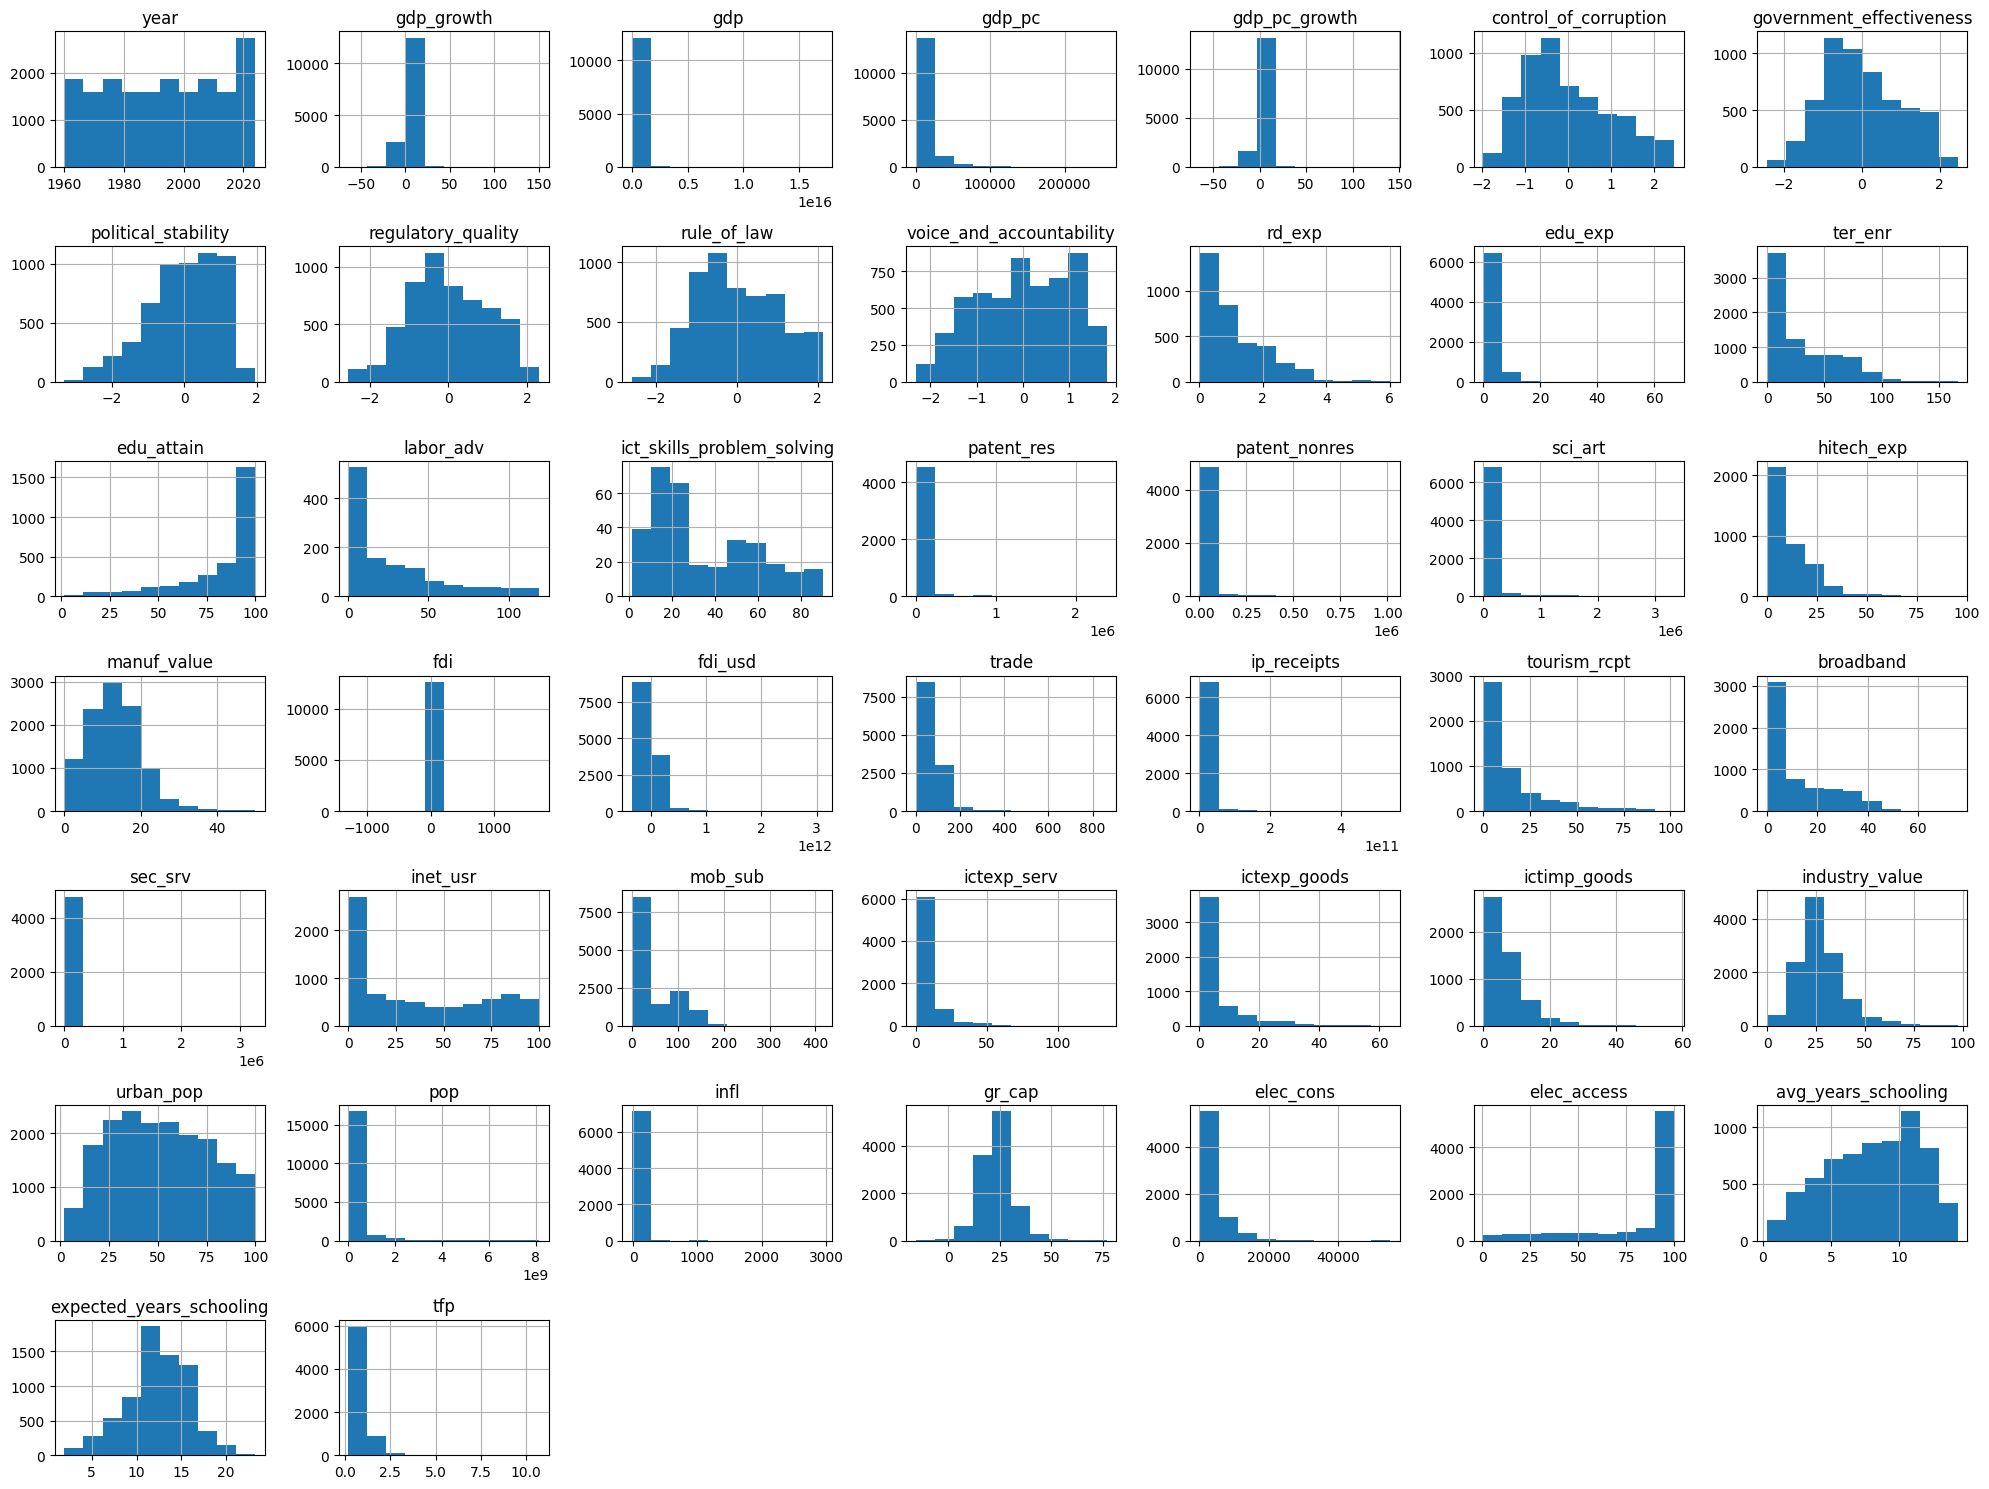


Distribution of Income Classifications:


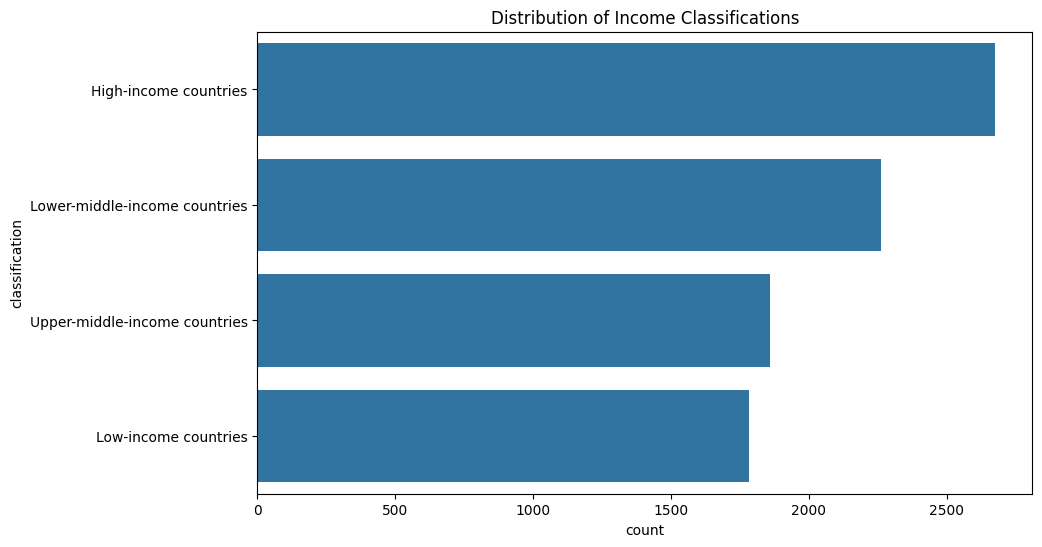

Time series by Country


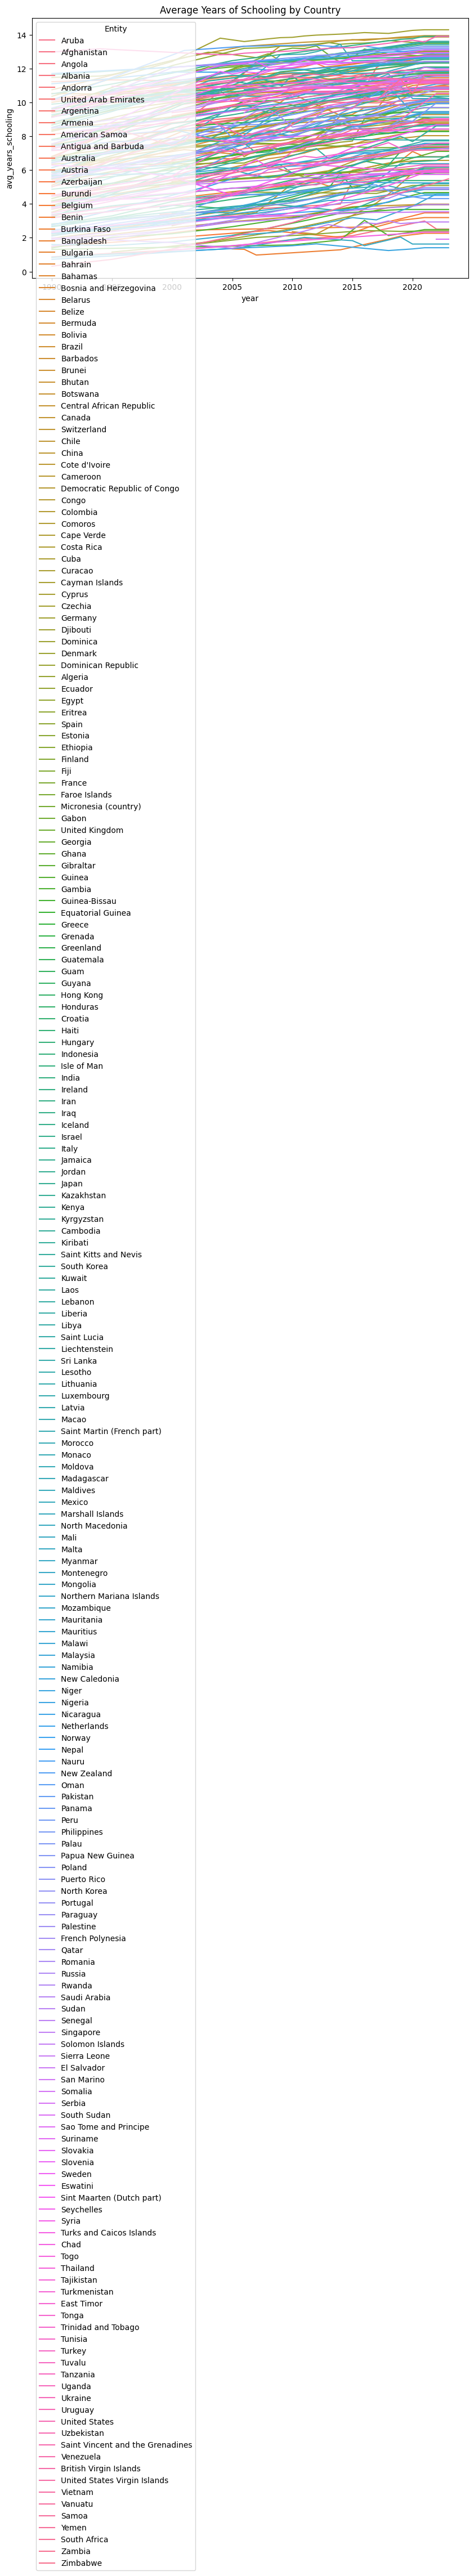


Correlation Matrix:


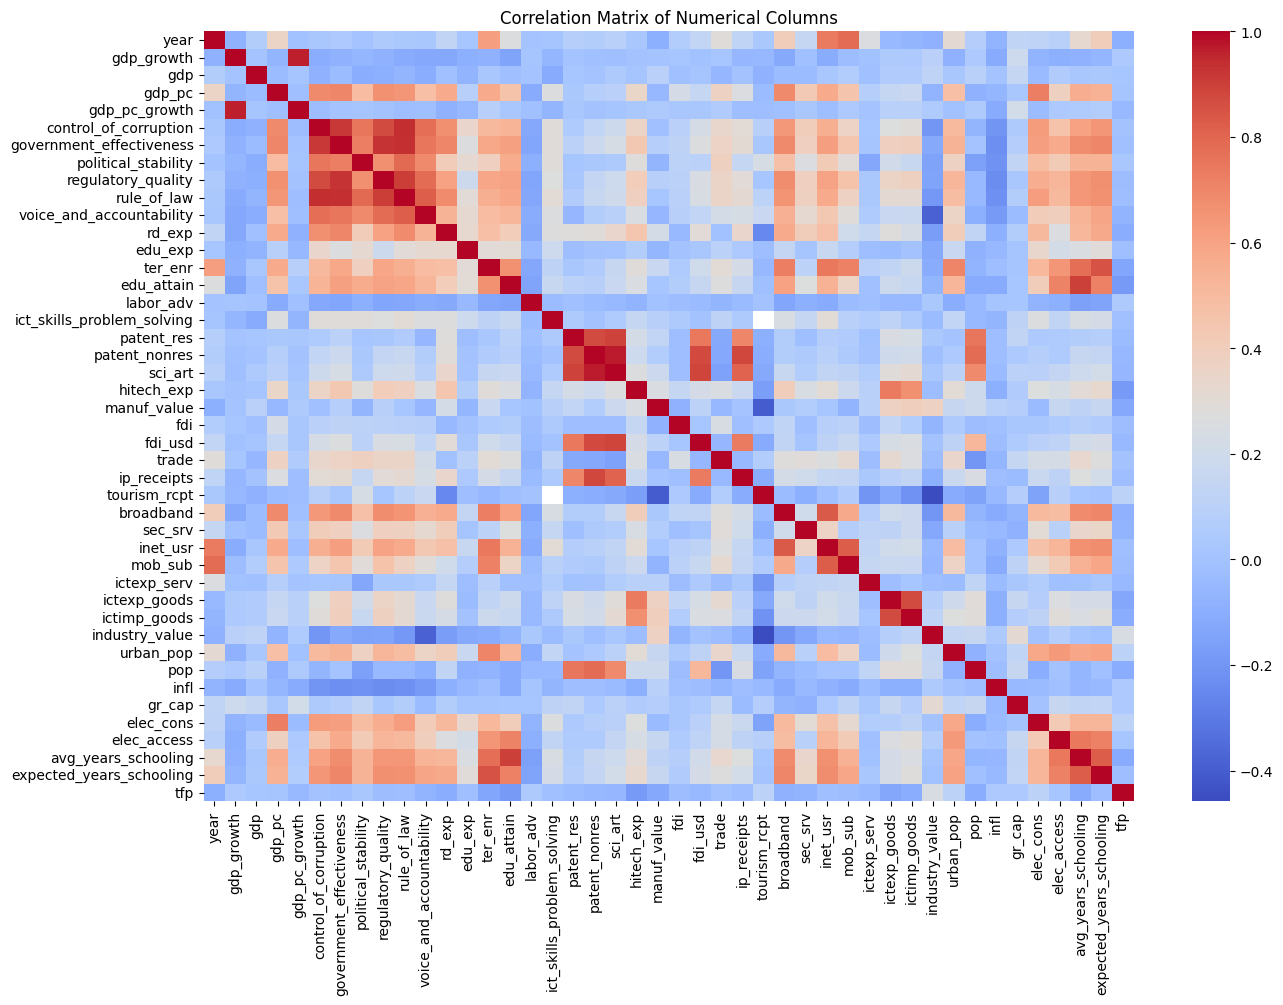

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
# Visualize distributions of numerical columns
print("\nDistribution of Numerical Columns:")
combined_df.hist(figsize=(20, 15))
plt.tight_layout()
plt.show()

# Visualize distribution of categorical columns (if any)
# Assuming 'classification' is a categorical column
if 'classification' in combined_df.columns:
    print("\nDistribution of Income Classifications:")
    plt.figure(figsize=(10, 6))
    sns.countplot(data=combined_df, y='classification', order=combined_df['classification'].value_counts().index)
    plt.title('Distribution of Income Classifications')
    plt.show()
if'Entity' in combined_df.columns:
    print("Time series by Country")
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=combined_df, x='year', y='avg_years_schooling', hue='Entity')
    plt.title('Average Years of Schooling by Country')
    plt.show()

# Visualize correlations between numerical columns
print("\nCorrelation Matrix:")
plt.figure(figsize=(15, 10))
sns.heatmap(combined_df.select_dtypes(include='number').corr(), annot=False, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Columns')
plt.show()